<a href="https://colab.research.google.com/github/Narennnnn/Fake-News-Classifier/blob/main/Fake_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Fake News Classifier Using LSTM

Dataset: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '/content/sample_data/WELFake_Dataset.csv'
df = pd.read_csv(file_path)

In [3]:
print(df.head)

<bound method NDFrame.head of        Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Bara

In [4]:
# drop the NAN values
df = df.dropna()
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [5]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
print(df.head)

<bound method NDFrame.head of                                                    title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
5      About Time! Christian Group Sues Amazon and SP...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
2       Now, most of the demonstrators gathered last ...      1  
3      A dozen politically active pastors came here

<Axes: ylabel='count'>

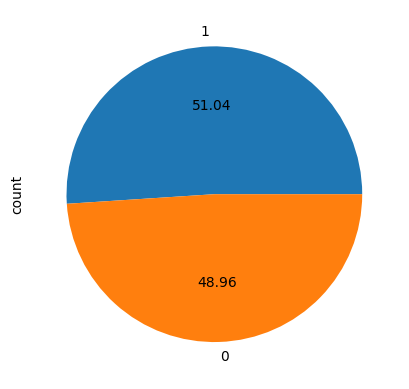

In [7]:
# 0 - Fake, 1 - Real
df['label'].value_counts().plot.pie(autopct='%.2f')

In [8]:
X = df.drop(columns=['label'])
# Get the independet features

In [9]:
y = df['label']
# Get the dependent features

In [10]:
X.head()

,title,text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...


In [11]:
y.head()

0    1
2    1
3    0
4    1
5    1
Name: label, dtype: int64

In [12]:
print(X.shape)
print(y.shape)

(71537, 2)
(71537,)


In [13]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [14]:
# Vocab_size = Unique words in our Corpus (entire document)
vocab_size = 10000

In [15]:
messages = X.copy()

# We have to reset index as we have used dropna() earlier, otherwise it will throw an error
messages.reset_index(inplace=True)

In [16]:
messages['title'][2]

'Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid'

In [17]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
### Dataset Preprocessing (Stemming, Lower casing text, Removing Stop Words)

# We will perform classification of News on the basis of the "TITLE" of news

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):

    # We are substituting everything apart from (a-z, A-Z) with a " " (space)
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])

    review = review.lower()
    review = review.split()

    # if a word is not in Stop Words,then only we will add it to review (list/array)
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [19]:
corpus[:30]

['law enforc high alert follow threat cop white blacklivesmatt fyf terrorist video',
 'unbeliev obama attorney gener say charlott rioter peac protest home state north carolina video',
 'bobbi jindal rais hindu use stori christian convers woo evangel potenti bid',
 'satan russia unv imag terrifi new supernuk western world take notic',
 'time christian group sue amazon splc design hate group',
 'dr ben carson target ir never audit spoke nation prayer breakfast',
 'hous intel chair trump russia fake stori evid anyth video',
 'sport bar owner ban nfl game show true american sport like speak rural america video',
 'latest pipelin leak underscor danger dakota access pipelin',
 'gop senat smack punchabl alt right nazi internet',
 'may brexit offer would hurt cost eu citizen eu parliament',
 'schumer call trump appoint offici overse puerto rico relief',
 'watch hilari ad call question health age clinton crime famili boss',
 'chang expect espn polit agenda despit huge subscrib declin breitbart'

In [20]:
max_length = max(len(sentence.split()) for sentence in corpus)

print("Maximum sentence length:", max_length)

Maximum sentence length: 47


In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout

In [22]:
# Here, we are converting the text (Corpus) into One Hot Representation for the given vocabulary size (i.e. 10000)
onehot_repr=[one_hot(words,vocab_size) for words in corpus]

In [23]:
# Note: The one hot representation returns the indexes assigned to a particular word
onehot_repr[:5]

[[1726, 7625, 1083, 8264, 4870, 7634, 6413, 9832, 7541, 8780, 4788, 363],
 [5718,
  1910,
  2002,
  283,
  8545,
  1243,
  5490,
  7565,
  5061,
  2270,
  7920,
  1760,
  2180,
  363],
 [7799, 3465, 5623, 7400, 2313, 687, 834, 2583, 6576, 70, 6782, 2140],
 [2075, 9078, 741, 5463, 7936, 9589, 3919, 7920, 5600, 7222, 4190],
 [9532, 834, 1524, 2903, 1771, 8578, 8995, 9298, 1524]]

Embedding

In [24]:
sentence_length = 50

# Adding padding to sentences so that all sentences are of same length i.e 50, to avoid varying input sizes
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sentence_length)
print(embedded_docs)

[[   0    0    0 ... 8780 4788  363]
 [   0    0    0 ... 1760 2180  363]
 [   0    0    0 ...   70 6782 2140]
 ...
 [   0    0    0 ... 5822 9426 3706]
 [   0    0    0 ... 4957 2983 9206]
 [   0    0    0 ...   43 6016 2582]]


In [25]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1726, 7625, 1083, 8264, 4870, 7634,
       6413, 9832, 7541, 8780, 4788,  363], dtype=int32)

**LSTM Model**

In [26]:
embedding_vector_features=100 # We will have a vector representation to text with only 100 features

model=Sequential()
model.add(Embedding(vocab_size, embedding_vector_features, input_length=sentence_length))
model.add(LSTM(100))
model.add(Dropout(0.2))

# LSTM layer (output) is fully connected to the Dense layer
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1080501 (4.12 MB)
Trainable params: 1080501 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [27]:
X_final = np.array(embedded_docs)
y_final = np.array(y)
X_final.shape,y_final.shape

((71537, 50), (71537,))

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

Model Training

In [29]:
# Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
749/749 [==============================] - 90s 116ms/step - loss: 0.2938 - accuracy: 0.8721 - val_loss: 0.2393 - val_accuracy: 0.8998
Epoch 2/10
749/749 [==============================] - 85s 114ms/step - loss: 0.1933 - accuracy: 0.9227 - val_loss: 0.2366 - val_accuracy: 0.9020
Epoch 3/10
749/749 [==============================] - 100s 133ms/step - loss: 0.1518 - accuracy: 0.9391 - val_loss: 0.2468 - val_accuracy: 0.9021
Epoch 4/10
749/749 [==============================] - 95s 127ms/step - loss: 0.1187 - accuracy: 0.9535 - val_loss: 0.2928 - val_accuracy: 0.9004
Epoch 5/10
749/749 [==============================] - 96s 128ms/step - loss: 0.0928 - accuracy: 0.9631 - val_loss: 0.3399 - val_accuracy: 0.8935
Epoch 6/10
749/749 [==============================] - 90s 120ms/step - loss: 0.0731 - accuracy: 0.9715 - val_loss: 0.3565 - val_accuracy: 0.8980
Epoch 7/10
749/749 [==============================] - 97s 129ms/step - loss: 0.0572 - accuracy: 0.9774 - val_loss: 0.4469 - val_a

Performance Matrics

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_log = model.predict(X_test)
y_pred = np.where(y_log>0.5,1,0)

acc = accuracy_score(y_test, y_pred)

confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

738/738 [==============================] - 17s 20ms/step
[[10262  1431]
 [ 1080 10835]]


In [31]:
# Accuracy
print(acc)

0.893637749915283


**Stacked LSTM**

In [32]:
embedding_vector_features=100
model1=Sequential()
model1.add(Embedding(vocab_size, embedding_vector_features, input_length=sentence_length))
model1.add(LSTM(100,return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(50,return_sequences=True))
model1.add(Dropout(0.1))

model1.add(LSTM(20))
model1.add(Dropout(0.1))

model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                5680      
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [33]:
# Training
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
749/749 [==============================] - 152s 195ms/step - loss: 0.3142 - accuracy: 0.8603 - val_loss: 0.2398 - val_accuracy: 0.9011
Epoch 2/10
749/749 [==============================] - 147s 196ms/step - loss: 0.1967 - accuracy: 0.9222 - val_loss: 0.2374 - val_accuracy: 0.9017
Epoch 3/10
749/749 [==============================] - 145s 194ms/step - loss: 0.1540 - accuracy: 0.9409 - val_loss: 0.2592 - val_accuracy: 0.8996
Epoch 4/10
749/749 [==============================] - 142s 189ms/step - loss: 0.1201 - accuracy: 0.9539 - val_loss: 0.2702 - val_accuracy: 0.8994
Epoch 5/10
749/749 [==============================] - 168s 224ms/step - loss: 0.0939 - accuracy: 0.9653 - val_loss: 0.3220 - val_accuracy: 0.8959
Epoch 6/10
749/749 [==============================] - 145s 194ms/step - loss: 0.0748 - accuracy: 0.9723 - val_loss: 0.3536 - val_accuracy: 0.8934
Epoch 7/10
749/749 [==============================] - 147s 196ms/step - loss: 0.0567 - accuracy: 0.9791 - val_loss: 0.4236 -

In [34]:
y_log_1 = model1.predict(X_test)
y_pred_1 = np.where(y_log_1>0.5,1,0)

acc_1 = accuracy_score(y_test, y_pred_1)
print(acc_1)

print()

confusion_mat_1 = confusion_matrix(y_test, y_pred_1)
print(confusion_mat_1)

738/738 [==============================] - 25s 29ms/step
0.8878346323280244

[[10014  1679]
 [  969 10946]]


In [36]:
print(acc_1)

0.8878346323280244


**Bidirectional LSTM**

In [37]:
embedding_vector_features=150
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_vector_features, input_length=sentence_length))
model2.add(Bidirectional(LSTM(200)))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 150)           1500000   
                                                                 
 bidirectional (Bidirection  (None, 400)               561600    
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 401       
                                                                 
Total params: 2062001 (7.87 MB)
Trainable params: 2062001 (7.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [38]:
model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10, batch_size=120)

Epoch 1/10
400/400 [==============================] - 276s 676ms/step - loss: 0.3016 - accuracy: 0.8669 - val_loss: 0.2395 - val_accuracy: 0.9011
Epoch 2/10
400/400 [==============================] - 268s 669ms/step - loss: 0.1916 - accuracy: 0.9229 - val_loss: 0.2386 - val_accuracy: 0.9014
Epoch 3/10
400/400 [==============================] - 265s 663ms/step - loss: 0.1519 - accuracy: 0.9402 - val_loss: 0.2602 - val_accuracy: 0.9033
Epoch 4/10
400/400 [==============================] - 269s 673ms/step - loss: 0.1218 - accuracy: 0.9529 - val_loss: 0.2832 - val_accuracy: 0.8982
Epoch 5/10
400/400 [==============================] - 260s 650ms/step - loss: 0.0968 - accuracy: 0.9623 - val_loss: 0.3282 - val_accuracy: 0.8961
Epoch 6/10
400/400 [==============================] - 272s 681ms/step - loss: 0.0776 - accuracy: 0.9697 - val_loss: 0.4113 - val_accuracy: 0.8963
Epoch 7/10
400/400 [==============================] - 273s 681ms/step - loss: 0.0621 - accuracy: 0.9768 - val_loss: 0.4177 -

In [39]:
y_log_2 = model2.predict(X_test)
y_pred_2 = np.where(y_log_2>0.5,1,0)

acc_2 = accuracy_score(y_test, y_pred_2)
print(acc_2)

print()

confusion_mat_2 = confusion_matrix(y_test, y_pred_2)
print(confusion_mat_2)

738/738 [==============================] - 65s 86ms/step
0.8888088783463233

[[10038  1655]
 [  970 10945]]
